In [1]:
import os
import re
import json
import time
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
cc = SmoothingFunction()
%matplotlib inline

In [2]:
stop = stopwords.words('english') + list(string.punctuation)

In [3]:
def get_seconds(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

def get_minutes(seconds):
    return seconds/60

def get_time_string(time_float):
    return datetime.datetime.utcfromtimestamp(time_float).strftime('%M:%S')

# Log Processor

In [4]:
class Log:
    def __init__(self, logfile):
        self.game_id = logfile['game_id']
        self.domain_id = logfile['domain_id']
        self.agent_ids = logfile['agent_ids']
        self.agent_labels = logfile['agent_labels']
        self.feedback = logfile['feedback']
        self.rounds, self.complete = self.load_rounds(logfile['rounds'])
        self.score = self.calculate_score()
        self.duration = self.calculate_duration()
        self.domains = self.get_domains()
        self.calculate_timestamps()
        self.check_feedback()

    def load_rounds(self, game_rounds):
        rounds = []
        for round_data in game_rounds:
            game_round = GameRound(round_data)
            rounds.append(game_round)
        if len(rounds) < 5:
            print("ERROR: Missing rounds in this game.")
            return (rounds, False)
        return (rounds, True)

    def calculate_score(self):
        score = 0
        for game_round in self.rounds:
            score += game_round.score
        return score
    
    def get_domains(self):
        path = self.rounds[0].images["A"][0][0].split("/")[0]
        return [domain for domain in path.split("_")]

    def calculate_timestamps(self):
        start_time = self.rounds[0].messages[0].timestamp
        for game_round in self.rounds:
            for mesage in game_round.messages:
                mesage.timestamp = datetime.datetime.utcfromtimestamp(mesage.timestamp - start_time)

    def calculate_duration(self):
        start_time = self.rounds[0].messages[0].timestamp
        end_time = self.rounds[-1].messages[-1].timestamp
        return get_time_string(end_time - start_time)
    
    def check_feedback(self):
        if "A" not in self.feedback:
            self.feedback["A"] = None
        if "B" not in self.feedback:
            self.feedback["B"] = None
            

class GameRound:
    def __init__(self, logfile_entry):
        self.round_nr = logfile_entry['round_nr']+1
        self.images = logfile_entry['images']
        self.score = self.calculate_score(logfile_entry['score'])
        if self.score > 6:
            print("WARNING: SCORE TOO LARGE!")
            self.score = 6
        self.messages = self.load_messages(logfile_entry['messages'])
        self.num_messages = self.count_text_messages()
        self.duration = self.calculate_duration(self.round_nr)
#         print("Duration: {}".format(self.duration))

    def load_messages(self, message_list):
        messages = []
        message_id = 0
        for message_data in message_list:
            message = Message(message_data, message_id)
            messages.append(message)
            message_id += 1
            
        if len(messages) == 0:
            print('ERROR: Missing messages for this game')
        return messages

    def calculate_score(self, score_dict):
        score = 0
        for player_score in score_dict.values():
            score += player_score
        return score
    
    def count_text_messages(self):
        count = 0
        for message in self.messages:
            if message.type == "text":
                count += 1
        return count

    def calculate_duration(self, round_nr):
        start_time = self.messages[0].timestamp
#         print("Start Time: {}".format(get_time_string(start_time)))
        
        for message in self.messages[::-1]:
            if message.type == 'feedback': 
                end_time = message.timestamp
#                 print("Last player submitted: {}".format(get_time_string(end_time)))
                return get_time_string(end_time - start_time)

class Message:
    def __init__(self, logfile_message, message_id):
        self.message_id = message_id
        self.agent_id = logfile_message['agent_id']
        self.agent_label = logfile_message['agent_label']
        self.text = logfile_message['message']
        self.speaker = logfile_message['speaker']
        self.timestamp = logfile_message['timestamp']
        self.turn = logfile_message['turn']
        self.type = self.determine_message_type()
        
    def determine_message_type(self):
        if not self.text.startswith("<"):
            return "text"
        else:
            return re.findall(r'<(.*?)>', self.text)[0]

In [5]:
def load_logs(filepath="ParlAI/parlai/mturk/core/logs/batch_1"):
    print("Loading logs from {}".format(filepath))
    logs = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.endswith(".json"):
#                 print("Loading {}".format(os.path.join(root, file)))
                with open(os.path.join(root, file), 'r') as logfile:
                    log = Log(json.load(logfile))
                    if log.complete: 
                        logs.append(log)
                    else:
                        print("GAME NOT COMPLETED")

    print("Complete. Loaded {} logs.".format(len(logs)))
    return logs


def get_messages(log, split=False, print_selections=True):
    message_list = []
    if len(log.rounds) != 5:
        print("Conversation was not completed.")
        return []
    for game_round in log.rounds:
        round_messages = []
        for message in game_round.messages:
            if message.type == 'text' or (print_selections and message.type == 'selection') :   
                round_messages.append((message.timestamp, message.speaker, message.text))

        if split:
            message_list.append(round_messages)
        else:
            message_list.extend(round_messages)
    return message_list


def print_conversation(log, split=False, print_selections=True, to_file = False):
    message_list = get_messages(log, split, print_selections)
    
    print("Game ID: {}".format(log.game_id))
    print("Domain ID: {}".format(log.domain_id))
    print("Player A: {}".format(log.agent_ids[0]))
    print("Player B: {}".format(log.agent_ids[1]))
    
    if to_file:
        if not os.path.exists("transcripts"):
            os.makedirs("transcripts")
        with open('transcripts/{}.txt'.format(log.game_id), 'w') as f:
            f.write("Game ID: {}\n".format(log.game_id))
            f.write("Domain ID: {}\n".format(log.domain_id))
            f.write("Player A: {}\n".format(log.agent_ids[0]))
            f.write("Player B: {}\n\n".format(log.agent_ids[1]))
    
    if split:
        for i, round_messages in enumerate(message_list):            
            print("- - Round {} - -".format(i+1))
            if to_file:
                with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                    f.write("- - Round {} - -\n".format(i+1))
            messages = print_messages(round_messages)
            if to_file:
                with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                    f.write(messages)
    else:
        messages = print_messages(message_list)
        if to_file:
            with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                f.write(messages)
#     print(log.feedback)


def print_messages(message_list):
    messages = ""
    for message in message_list:
        timestamp = message[0].strftime('%M:%S')
        print("[{}] {}: {}".format(timestamp, message[1], message[2]))
        messages += "[{}] {}: {}\n".format(timestamp, message[1], message[2])
    return messages


def print_game_statistics(log, to_file=False):
    print("\n- - Game statistics - -")
    print("Duration: {} min. Score: {}/30 points.".format(log.duration, log.score))
    
    if to_file:
        with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
            f.write("\n- - Game statistics - -\n") 
            f.write("Duration: {} min. Score: {}/30 points.\n".format(log.duration, log.score)) 
    stats = ""
    for i, game_round in enumerate(log.rounds):
        print("[Round {}] Duration: {} min. Score: {}/6 points. Number of messages: {}.".format(i, game_round.duration, game_round.score, game_round.num_messages))
        stats += "[Round {}] Duration: {} min. Score: {}/6 points. Number of messages: {}.\n".format(i, game_round.duration, game_round.score, game_round.num_messages)
        
    if to_file:
            with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                f.write(stats)

In [6]:
def collect_dataset(logs):
    labels = ["Game_ID", "Game_Domain_ID", "Game_Domain_1", "Game_Domain_2", "Game_Duration", "Game_Score", \
              "Feedback_A", "Feedback_B", \
              "Round_Nr", "Round_Duration", "Round_Scores", "Round_Images_A", "Round_Images_B", \
              "Message_Nr", "Message_Timestamp", "Message_Turn", "Message_Agent_ID", "Message_Agent_Label", \
              "Message_Speaker", "Message_Type", "Message_Text"]
    dataset = []
    for log in logs:
        game_data = [log.game_id, log.domain_id, log.domains[0], log.domains[1], get_seconds(log.duration), log.score, log.feedback["A"], log.feedback["B"]]
        for game_round in log.rounds:
            round_data = [game_round.round_nr, get_seconds(game_round.duration), game_round.score, game_round.images["A"], game_round.images["B"]]
            for message in game_round.messages:
                message_data = [message.message_id, message.timestamp, message.turn, message.agent_id, message.agent_label, \
                                message.speaker, message.type, message.text] 
                dataset.append(game_data + round_data + message_data)
                
    df = pd.DataFrame(dataset, columns=labels)
                
    return df 

# Print recorded Conversations

In [7]:
path = "logs/batch_1"

In [8]:
logs = load_logs(path)
nr_logs = len(logs)
for i, log in enumerate(logs):
    print("\n- - Game {} - -".format(i+1))

    print_conversation(log, split=True, print_selections=True, to_file=True)    
    print_game_statistics(log, to_file=True)

Loading logs from logs/batch_1
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
ERROR: Missing rounds in this game.
GAME NOT COMPLETED
Complete. Loaded 98 logs.

- - Game 1 - -
Game ID: 3E337GFOLA6SHTCH5CVZ47SAOTUGN63AZHRG4CU5IO2L8M9RMHA17OCVF038
Domain ID: 57
Player A: A3AY0315YWWNXY
Player B: A22ABLVEI5EGPL
- - Round 1 - -
[00:00] B: Hi!
[00:12] A: Hey.
[00:25] A: You can list your yellow boxes first and I'll go after you are done.
[00:32] B: Do you have a photo with a girl and a stuffed panda on a bed?
[00:41] A: I have it.
[00:43] A: <selection> <com> person_bed/COCO_train2014_000000112029.jpg
[00:45] B: <selection> <com> person_bed/COCO_train2014_000000112029.jpg
[00:54] B: Do you have a photo with a pers

[06:04] B: me too
- - Round 3 - -
[06:22] B: I have the laptop with the vase of flowers.
[06:24] A: red closed laptop with phones on top?
[06:34] A: I don't have the flowers
[06:40] B: I don't have a red laptop this time.
[06:41] B: <selection> <dif> dining_table_laptop/COCO_train2014_000000259745.jpg
[06:48] A: laptop with faces?
[06:53] A: <selection> <dif> dining_table_laptop/COCO_train2014_000000468357.jpg
[07:02] B: I don't have the laptop with the faces.
[07:08] A: <selection> <dif> dining_table_laptop/COCO_train2014_000000096757.jpg
[07:16] B: I have a coffee in the foreground with a stuffed animal on it.
[07:19] A: do you have the laptop with the mouse on top?
[07:42] A: I have a coffee with the mouse on top
[07:52] B: I don't see one with a mouse on top.
[07:54] B: <selection> <com> dining_table_laptop/COCO_train2014_000000483794.jpg
[08:15] A: A little animal it may not be a mouse
[08:16] B: My last one has a laptop next to half a glass of orange drink with a straw.
[08:35] A

[05:59] B: <selection> <dif> person_boat/COCO_train2014_000000492268.jpg
[06:04] A: Do you have the scuba guys this time?
[06:06] A: <selection> <dif> person_boat/COCO_train2014_000000012574.jpg
[06:08] B: yes
[06:13] A: Me too.
[06:16] B: <selection> <com> person_boat/COCO_train2014_000000461183.jpg
[06:18] A: I also have the log lady.
[06:26] A: <selection> <com> person_boat/COCO_train2014_000000461183.jpg
[06:30] B: i do not
[06:36] B: <selection> <dif> person_boat/COCO_train2014_000000424434.jpg
[06:38] A: <selection> <dif> person_boat/COCO_train2014_000000004834.jpg
[06:54] A: OK. I am ready to submit. What other pictures do you have?
[07:13] B: the woman making food on the boat from the first page
[07:28] A: OK. I confirm I don't have that one. I am submitting.
- - Round 4 - -
[07:53] B: man on a boat with dog holding a beer
[08:00] A: Yes. I have that one.
[08:02] A: <selection> <com> person_boat/COCO_train2014_000000436717.jpg
[08:04] B: sail boat boy
[08:07] B: <selection> <co

[01:08] A: <selection> <dif> person_elephant/COCO_train2014_000000576598.jpg
[01:13] A: ok..ready
[01:24] B: a woman wearing a light green shirt, petting an elephants face.
[01:33] A: don't have
[01:35] B: <selection> <dif> person_elephant/COCO_train2014_000000296747.jpg
[01:50] B: a headless person on the left, wearing a dark green shirt, standing next to an elephant
[01:59] A: no
[02:02] B: <selection> <dif> person_elephant/COCO_train2014_000000013763.jpg
[02:14] B: i'm good to go
[02:19] A: ok
- - Round 2 - -
[02:41] A: headless guy with elephant, guy in green top
[02:53] B: don't have it.
[02:57] A: <selection> <dif> person_elephant/COCO_train2014_000000013763.jpg
[03:12] A: guy with white shirt, standing in front of elephant with man riding elephant
[03:22] B: got it.
[03:23] B: <selection> <com> person_elephant/COCO_train2014_000000576598.jpg
[03:25] A: <selection> <com> person_elephant/COCO_train2014_000000576598.jpg
[03:42] A: photo of an elephant making a painting..man with wh

# Create Dataframe

In [9]:
dataset = collect_dataset(logs)
dataset.columns

Index(['Game_ID', 'Game_Domain_ID', 'Game_Domain_1', 'Game_Domain_2',
       'Game_Duration', 'Game_Score', 'Feedback_A', 'Feedback_B', 'Round_Nr',
       'Round_Duration', 'Round_Scores', 'Round_Images_A', 'Round_Images_B',
       'Message_Nr', 'Message_Timestamp', 'Message_Turn', 'Message_Agent_ID',
       'Message_Agent_Label', 'Message_Speaker', 'Message_Type',
       'Message_Text'],
      dtype='object')

In [10]:
dataset.to_csv('conversations.csv', index = False)

In [11]:
dataset.to_pickle('conversations.pickle')

In [12]:
game_times = dataset.groupby('Game_ID').mean()['Game_Duration']
game_times_list = [get_minutes(duration) for duration in list(game_times)]
print(game_times_list)

[19.383333333333333, 12.916666666666666, 20.166666666666668, 14.0, 13.866666666666667, 14.1, 16.483333333333334, 7.7166666666666668, 12.066666666666666, 36.75, 39.100000000000001, 13.933333333333334, 18.233333333333334, 21.100000000000001, 16.100000000000001, 13.316666666666666, 20.383333333333333, 27.633333333333333, 8.4166666666666661, 10.050000000000001, 12.5, 22.916666666666668, 10.666666666666666, 29.649999999999999, 23.066666666666666, 16.716666666666665, 13.083333333333334, 18.366666666666667, 26.666666666666668, 13.116666666666667, 13.75, 10.533333333333333, 13.283333333333333, 18.850000000000001, 12.15, 17.183333333333334, 8.8000000000000007, 20.983333333333334, 18.600000000000001, 16.183333333333334, 10.1, 21.666666666666668, 14.516666666666667, 10.199999999999999, 23.616666666666667, 12.983333333333333, 17.866666666666667, 6.1833333333333336, 15.75, 13.4, 18.633333333333333, 13.433333333333334, 11.199999999999999, 4.7166666666666668, 36.299999999999997, 15.316666666666666, 6

## Average Game Time

In [13]:
print(np.mean(game_times_list))

16.4224489796


In [14]:
under_12 = [time for time in game_times_list if time < 12]
print(len(under_12))
print(under_12)

25
[7.7166666666666668, 8.4166666666666661, 10.050000000000001, 10.666666666666666, 10.533333333333333, 8.8000000000000007, 10.1, 10.199999999999999, 6.1833333333333336, 11.199999999999999, 4.7166666666666668, 6.9666666666666668, 9.6333333333333329, 9.0666666666666664, 8.8499999999999996, 10.933333333333334, 6.833333333333333, 10.916666666666666, 7.3499999999999996, 8.5666666666666664, 9.7166666666666668, 8.0500000000000007, 10.216666666666667, 8.1166666666666671, 11.366666666666667]


## Distribution of Game Times

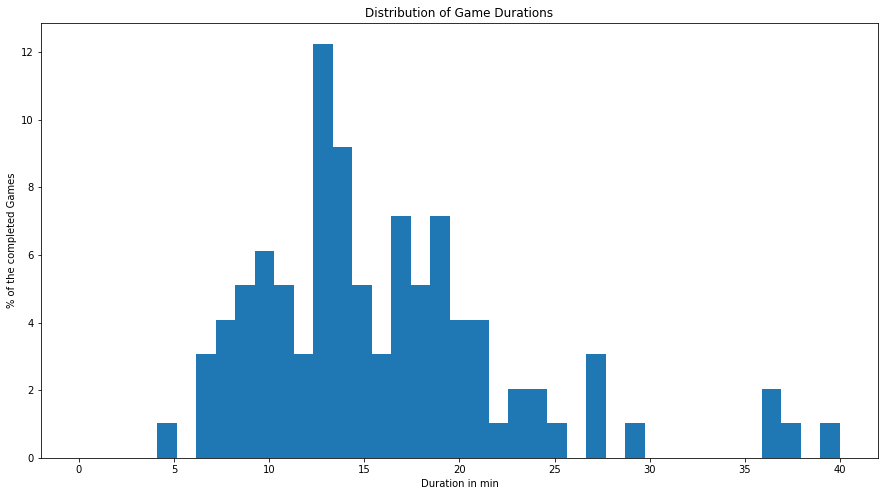

In [15]:
f = plt.figure(figsize=(15,8))
plt.hist(game_times_list, bins=np.linspace(0,40,40), weights=np.zeros_like(game_times_list) + 100. / len(game_times_list))  # arguments are passed to np.histogram
plt.title("Distribution of Game Durations")
plt.xlabel("Duration in min")
plt.ylabel("% of the completed Games")
plt.draw()
ax = plt.gca()
xticks = [str(label.get_text())+" min" for label in ax.get_xticklabels()][1:-1]
ax.set_xticklabels = xticks
plt.draw()
plt.show()
f.savefig("time_distro.pdf", bbox_inches='tight')

# Game Statistics

In [16]:
games_df = dataset.groupby('Game_ID')

In [17]:
game_statistics = defaultdict(lambda: (defaultdict(lambda: [])))

for game_df in games_df:
#     print("Game {}".format(game_df[0]))
    rounds_df = game_df[1].groupby('Round_Nr')
    for round_df in rounds_df:
#         print("Round {}".format(round_df[0]))
        player_data_df = round_df[1].groupby('Message_Agent_ID')
        token_sum = 0
        message_sum = 0
        for player_df in player_data_df:
            
            messages = player_df[1].loc[player_df[1]['Message_Type'] == 'text']
            message_list = messages['Message_Text'].tolist()
            no_tokens = 0
            for m in message_list:
                tokens = [i for i in word_tokenize(m.lower()) if i not in stop]
#                 print(tokens)
#                 print(len(tokens))
                no_tokens += len(tokens)
            token_sum += no_tokens
            message_sum += len(message_list)
#             print("Agent {} used {} tokens in {} messages.".format(player_df[0], no_tokens, len(message_list)))
            
        game_statistics["tokens"][round_df[0]].append(token_sum)
        game_statistics["messages"][round_df[0]].append(message_sum)
        game_statistics["duration"][round_df[0]].append(round_df[1].mean()["Round_Duration"])
#         print("Total tokens: {}. Total messages: {}. Duration: {}".format(token_sum, message_sum, get_time_string(round_df[1].mean()["Round_Duration"])))
#     print("\n-------\n")
   

In [18]:
def plot_game_data(mu, sigma, t, title, x_label, y_label, filename=None):
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.plot(t, mu, lw=2, label='mean population 1', color='blue')
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor='blue', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(t)
    ax.grid()
    fig.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight')

## Word Tokens per Round

Round 1: Token counts [61, 65, 57, 23, 29, 46, 27, 33, 53, 48, 24, 63, 64, 49, 70, 39, 72, 33, 36, 78, 27, 59, 66, 88, 114, 28, 57, 95, 70, 47, 53, 34, 45, 59, 57, 49, 61, 61, 65, 52, 36, 23, 36, 29, 58, 37, 50, 31, 26, 56, 60, 88, 55, 21, 80, 70, 33, 25, 46, 55, 114, 78, 88, 63, 70, 53, 81, 45, 57, 52, 57, 29, 109, 62, 91, 42, 67, 10, 44, 50, 87, 38, 24, 53, 60, 61, 57, 149, 46, 86, 147, 42, 30, 66, 36, 33, 49, 50]
Round 2: Token counts [53, 36, 23, 26, 69, 79, 35, 44, 34, 46, 23, 42, 39, 52, 64, 33, 54, 28, 45, 34, 43, 39, 30, 107, 37, 21, 52, 34, 37, 43, 44, 22, 86, 36, 35, 29, 40, 43, 108, 44, 35, 14, 31, 33, 37, 25, 26, 42, 22, 45, 78, 59, 29, 21, 92, 55, 34, 28, 42, 36, 46, 53, 53, 39, 66, 32, 26, 35, 46, 54, 45, 26, 86, 35, 39, 64, 68, 14, 52, 28, 39, 29, 19, 63, 45, 26, 40, 66, 36, 45, 102, 33, 26, 36, 29, 28, 37, 57]
Round 3: Token counts [48, 29, 22, 33, 44, 52, 39, 18, 28, 29, 18, 38, 31, 38, 60, 23, 56, 37, 17, 29, 33, 22, 36, 73, 51, 22, 50, 24, 42, 36, 61, 55, 27, 46, 34,

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


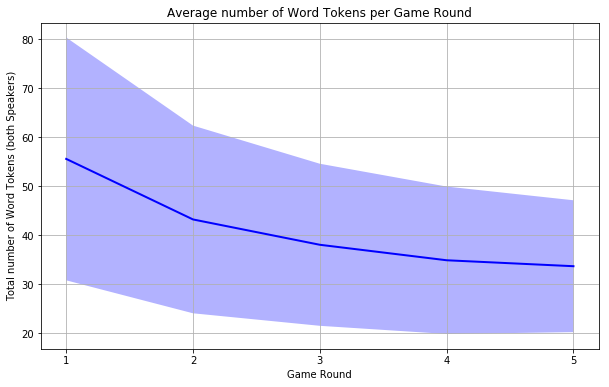

In [19]:
data_array = np.empty([5, nr_logs])

for round_nr, token_counts in game_statistics["tokens"].items():    
    print("Round {}: Token counts {}".format(round_nr, token_counts))
    data_array[round_nr-1] = token_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average number of Word Tokens per Game Round'
x_label = 'Game Round'
y_label = 'Total number of Word Tokens (both Speakers)'
filename = 'tokens.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


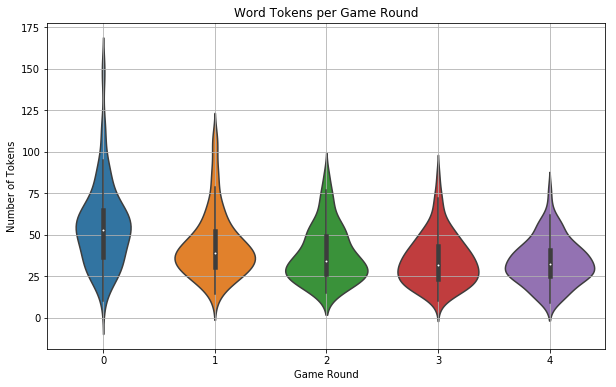

In [20]:
message_df = pd.DataFrame(data_array.T)
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(data=message_df)    
    
ax.set_title("Word Tokens per Game Round")
ax.set_xlabel("Game Round")
ax.set_ylabel("Number of Tokens")
# ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("tokens_violin_cut.pdf", bbox_inches='tight')


## Vocabulary

In [21]:
messages = dataset.loc[dataset['Message_Type'] == 'text']['Message_Text'].tolist()

tokens = []
for message in messages:        
    tokens.extend([i for i in word_tokenize(message.lower()) if i not in stop])

token_counter = Counter(tokens)
print("Vocabulary size: {} tokens.".format(len(token_counter)))
print(token_counter.most_common(100))

Vocabulary size: 1771 tokens.
[('yes', 694), ('one', 641), ('woman', 415), ('man', 396), ("n't", 369), ('guy', 315), ('red', 308), ('shirt', 303), ('white', 288), ('black', 272), ('ok', 270), ('girl', 221), ('blue', 220), ("'s", 209), ('lady', 203), ('two', 181), ('green', 180), ('done', 173), ('holding', 156), ('orange', 156), ('laptop', 155), ('boy', 150), ('fridge', 150), ('got', 148), ('pizza', 146), ('picture', 143), ('bed', 139), ('dog', 130), ('pink', 128), ('highlighted', 128), ('next', 125), ('wearing', 122), ('okay', 119), ('sitting', 114), ('nope', 109), ("'m", 108), ('front', 104), ('little', 101), ('2', 99), ('bike', 99), ('cake', 99), ('table', 96), ('also', 93), ('good', 93), ('brown', 89), ('photo', 87), ('hat', 87), ('suitcase', 86), ('elephant', 85), ('right', 84), ('baby', 81), ('looking', 81), ('boat', 81), ('person', 78), ('yellow', 77), ('dogs', 77), ('time', 77), ('kid', 77), ('standing', 77), ('last', 75), ('taking', 74), ('phone', 73), ('people', 66), ('bench',

## Messages per Round

Round 1: Message counts [14, 20, 20, 10, 9, 16, 11, 9, 13, 14, 15, 18, 15, 17, 23, 11, 17, 12, 10, 18, 10, 16, 20, 23, 26, 11, 14, 36, 10, 12, 13, 18, 11, 14, 14, 14, 13, 17, 16, 9, 13, 13, 9, 9, 18, 13, 14, 9, 10, 16, 15, 15, 12, 9, 19, 15, 8, 9, 13, 15, 35, 20, 17, 17, 19, 12, 22, 19, 16, 16, 14, 12, 23, 17, 23, 12, 16, 8, 17, 9, 16, 9, 15, 19, 17, 15, 19, 32, 14, 24, 35, 12, 9, 15, 14, 17, 16, 18]
Round 2: Message counts [13, 13, 11, 8, 18, 22, 19, 12, 12, 16, 14, 15, 12, 19, 19, 13, 18, 8, 20, 10, 13, 14, 10, 28, 13, 10, 13, 12, 11, 12, 14, 10, 23, 12, 10, 16, 12, 13, 30, 8, 12, 8, 14, 11, 14, 9, 9, 12, 9, 10, 16, 11, 11, 9, 23, 14, 10, 11, 11, 12, 18, 16, 12, 14, 16, 10, 11, 14, 12, 14, 11, 12, 19, 9, 12, 17, 18, 10, 18, 8, 9, 9, 10, 16, 16, 10, 11, 16, 14, 15, 21, 10, 10, 11, 10, 11, 14, 15]
Round 3: Message counts [13, 10, 9, 13, 15, 17, 18, 11, 11, 11, 8, 14, 10, 11, 17, 10, 18, 12, 10, 7, 12, 8, 13, 22, 13, 15, 17, 10, 14, 11, 17, 14, 12, 12, 10, 16, 10, 14, 24, 14, 9, 8, 9, 8

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


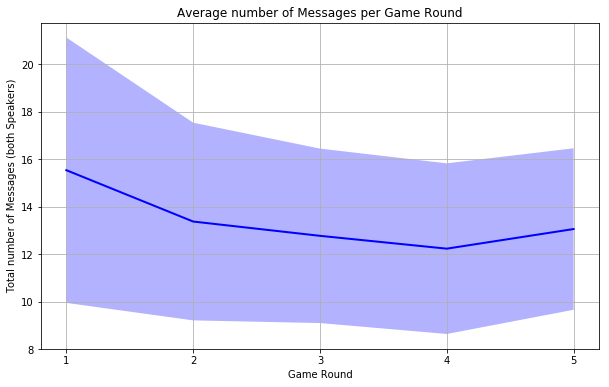

In [22]:
data_array = np.empty([5, nr_logs])

for round_nr, message_counts in game_statistics["messages"].items():    
    print("Round {}: Message counts {}".format(round_nr, message_counts))
    data_array[round_nr-1] = message_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average number of Messages per Game Round'
x_label = 'Game Round'
y_label = 'Total number of Messages (both Speakers)'
filename = 'messages.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


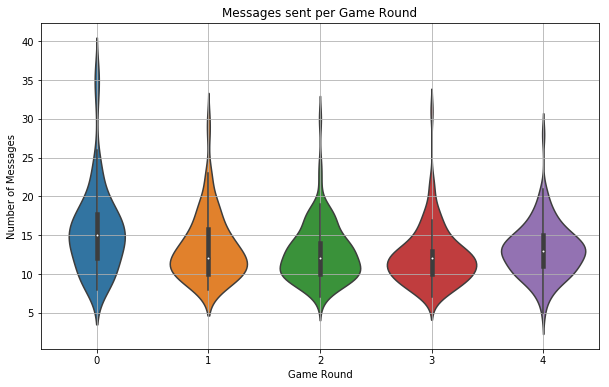

In [23]:
message_df = pd.DataFrame(data_array.T)
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(data=message_df)    
    
ax.set_title("Messages sent per Game Round")
ax.set_xlabel("Game Round")
ax.set_ylabel("Number of Messages")
# ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("messages_violin_cut.pdf", bbox_inches='tight')


## Duration per Round

Round 1: Duration [223.0, 246.0, 419.0, 105.0, 106.0, 199.0, 99.0, 87.0, 182.0, 574.0, 158.0, 224.0, 382.0, 362.0, 257.0, 191.0, 193.0, 216.0, 75.0, 242.0, 130.0, 360.0, 207.0, 343.0, 614.0, 124.0, 233.0, 514.0, 730.0, 135.0, 182.0, 126.0, 110.0, 318.0, 188.0, 208.0, 117.0, 287.0, 163.0, 230.0, 137.0, 170.0, 106.0, 110.0, 301.0, 170.0, 304.0, 89.0, 161.0, 227.0, 204.0, 201.0, 158.0, 53.0, 414.0, 244.0, 82.0, 127.0, 140.0, 166.0, 498.0, 278.0, 313.0, 172.0, 289.0, 178.0, 274.0, 417.0, 181.0, 103.0, 420.0, 192.0, 211.0, 283.0, 411.0, 163.0, 115.0, 79.0, 205.0, 122.0, 391.0, 114.0, 139.0, 280.0, 145.0, 256.0, 140.0, 576.0, 231.0, 300.0, 846.0, 116.0, 149.0, 205.0, 375.0, 144.0, 213.0, 201.0]
Round 2: Duration [197.0, 105.0, 101.0, 87.0, 223.0, 226.0, 417.0, 128.0, 117.0, 541.0, 323.0, 153.0, 124.0, 181.0, 210.0, 121.0, 150.0, 202.0, 184.0, 68.0, 175.0, 349.0, 83.0, 518.0, 162.0, 88.0, 152.0, 174.0, 317.0, 109.0, 159.0, 65.0, 281.0, 141.0, 87.0, 121.0, 101.0, 238.0, 313.0, 125.0, 118.0, 10

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


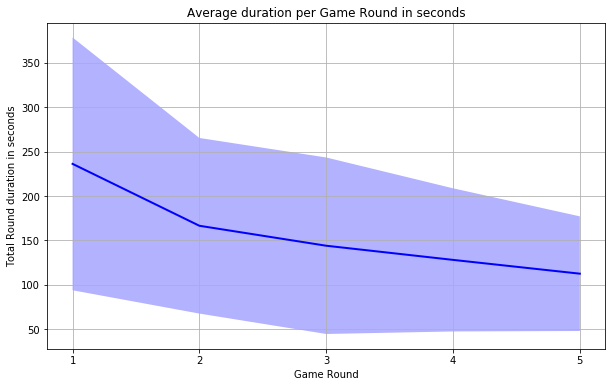

In [24]:
data_array = np.empty([5, nr_logs])

for round_nr, duration in game_statistics["duration"].items():    
    print("Round {}: Duration {}".format(round_nr, duration))
    data_array[round_nr-1] = duration
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average duration per Game Round in seconds'
x_label = 'Game Round'
y_label = 'Total Round duration in seconds'
filename = 'duration.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


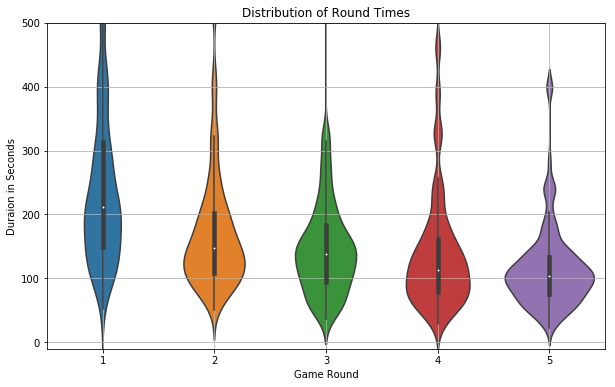

In [25]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(x="Round_Nr", y="Round_Duration", data=dataset)    
    
ax.set_title("Distribution of Round Times")
ax.set_xlabel("Game Round")
ax.set_ylabel("Duraion in Seconds")
ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("durations_violin_cut.pdf", bbox_inches='tight')



In [26]:
# for game_id, game_df in games_df:
#     selections = game_df.loc[game_df['Message_Type'] == 'selection']['Message_Text']
#     sel_images = [elements.split()[2] for elements in selections]
#     print(len(set(sel_images)))

## Worker Evaluations

In [27]:
dataset.columns

Index(['Game_ID', 'Game_Domain_ID', 'Game_Domain_1', 'Game_Domain_2',
       'Game_Duration', 'Game_Score', 'Feedback_A', 'Feedback_B', 'Round_Nr',
       'Round_Duration', 'Round_Scores', 'Round_Images_A', 'Round_Images_B',
       'Message_Nr', 'Message_Timestamp', 'Message_Turn', 'Message_Agent_ID',
       'Message_Agent_Label', 'Message_Speaker', 'Message_Type',
       'Message_Text'],
      dtype='object')

In [28]:
games_df = dataset.groupby("Game_ID")

In [29]:
feedback_dict = {0: [], 1: [], 2: []}

for _, f in games_df:
    f_a = f['Feedback_A'].unique()[0]
    f_b = f['Feedback_B'].unique()[0]
    
    if f_a and f_b:    
        elements = f_a.split("<&>")
        for i, element in enumerate(elements):
            value = element.split(":", 1)[1]
            if i < 3:
                feedback_dict[i].append(int(value))
#             else:
#                 print(value)

        elements = f_b.split("<&>")
        for i, element in enumerate(elements):
            value = element.split(":", 1)[1]
            if i < 3:
                feedback_dict[i].append(int(value))
#             else:
#                 print(value)

print("Overall collaboration with my partner worked well:")
print(np.sum(feedback_dict[0]) / float(len(feedback_dict[0])))
print(Counter(feedback_dict[0]))
print("I understood the descriptions of my partner well:")
print(np.sum(feedback_dict[1]) / float(len(feedback_dict[1])))
print(Counter(feedback_dict[1]))
print("My partner seemed to understand me well:")
print(np.sum(feedback_dict[2]) / float(len(feedback_dict[2])))
print(Counter(feedback_dict[2]))

Overall collaboration with my partner worked well:
5.0
Counter({5: 190})
I understood the descriptions of my partner well:
5.0
Counter({5: 190})
My partner seemed to understand me well:
5.0
Counter({5: 190})


In [30]:
scores = defaultdict(lambda: [])

for log in logs:
    for g_round in log.rounds:
        scores[g_round.round_nr].append(g_round.score)  
        
print(scores)

defaultdict(<function <lambda> at 0x7f6eb113fa60>, {1: [6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 5, 6, 5, 4, 5, 6, 4, 6], 2: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 2, 4, 6, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 4, 5, 6, 4, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6], 3: [6, 6, 6, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 5, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6], 4: [6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 3, 6, 5, 6, 6, 6,

In [31]:
data_array = np.empty([5, nr_logs])

for round_nr, round_scores in scores.items():    
    print("Round {}: Scores: {}".format(round_nr, round_scores))
    data_array[round_nr-1] = round_scores

Round 1: Scores: [6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 5, 6, 5, 4, 5, 6, 4, 6]
Round 2: Scores: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 2, 4, 6, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 4, 5, 6, 4, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6]
Round 3: Scores: [6, 6, 6, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 5, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6]
Round 4: Scores: [6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 3, 6, 5, 6, 6, 6

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


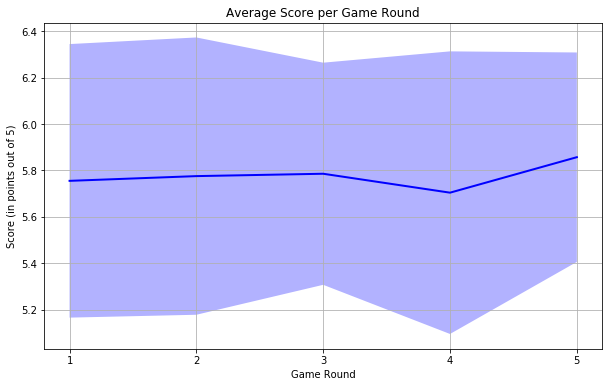

In [32]:
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average Score per Game Round'
x_label = 'Game Round'
y_label = 'Score (in points out of 5)'
filename = 'points.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

In [34]:
# sns.plot(kind='bar', stacked=True)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


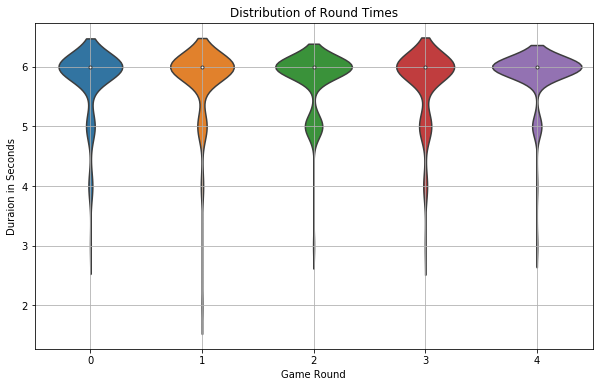

In [35]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(data=data_array.T)    
    
ax.set_title("Distribution of Round Times")
ax.set_xlabel("Game Round")
ax.set_ylabel("Duraion in Seconds")
# ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("points_violin_cut.pdf", bbox_inches='tight')

## Finding questions

In [62]:
message_df = dataset.loc[dataset['Message_Type'] == 'text'][['Message_Text', 'Round_Nr']]
q_words = ['who', 'what', 'when', 'where', 'why', 'how', 'is', 'can', 'does', 'do', 'does']

questions = []
question_stats = defaultdict(lambda: [0,0])
for index, row in message_df.iterrows():
    message = row['Message_Text']
#     print(message)
    if message[-1] == '?' or message.split()[0].lower() in q_words:
#         print("QUESTION")
        questions.append(message)
        question_stats[row['Round_Nr']][1] += 1
    question_stats[row['Round_Nr']][0] += 1

In [67]:
print(message_df.shape[0])
print(len(questions))
print(questions)

6565
1064
['Do you have a photo with a girl and a stuffed panda on a bed?', 'Do you have a photo with a person and two dogs on a bed?', 'Do you have a photo with an asian man holding a baby on a bed?', 'A woman lying down on a surfboard, tan shirt?', 'Male, black wet suit on a surfboard in the water?', 'Is the surfboard somewhat cream and it has "OLW" on it?', 'Same picture from before, surfboard with shark and time clock on it?', 'Do you have any more questions?', 'Man with red helmet carrying a green surfboard same as before?', 'What about you?', 'Topless guy on bike, white surfboard with 2 red stripes, headed left, same as before?', '2 kids, one carrying a red surfboard, the other carrying a white one?', 'Guy, red helmet, carrying green surfboard, same as before?', 'What about you?', 'sitting on a bench?', 'got the guy on the bench with a phone? no?', 'man and woman in black shirts looking at a  phone?', 'woman in a vest interviewing a man wearing a nice hat?', 'man in blue shirt wi

In [68]:
question_stats

defaultdict(<function __main__.<lambda>>,
            {1: [1523, 286],
             2: [1311, 213],
             3: [1252, 203],
             4: [1199, 182],
             5: [1280, 180]})

In [72]:
tips = sns.load_dataset("tips")

In [73]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


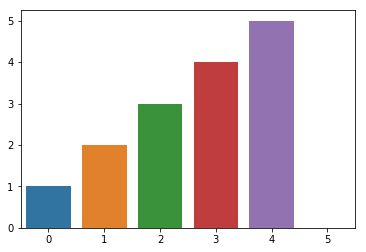

In [71]:
ax = sns.barplot(data=question_stats)

## Reference Grounding Heuristiscs

In [ ]:
with open('captions_train2014.json', 'r') as f:
    captions = json.load(f)

In [ ]:
def make_caption_dict(captions):
    caption_dict = defaultdict(lambda: [])
    for caption in captions['annotations']:
        caption_dict[caption['image_id']].append(caption['caption'])
    return caption_dict

In [ ]:
caption_dict = make_caption_dict(captions)

In [ ]:
HEURISTICS_VERBOSE = True

game_statistics = defaultdict(lambda: (defaultdict(lambda: [])))

for game_df in games_df:
    
    print(game_df[1]["Game_ID"].unique())
    
    highlighted_images = []
    
    rounds_df = game_df[1].groupby('Round_Nr')
    for round_df in rounds_df:       
        selections = round_df[1].loc[round_df[1]['Message_Type'] == 'selection']['Message_Text'].tolist()      
        highlighted_images.extend([int(image_link.split('_')[-1].split('.')[0].lstrip('0')) for image_link in set([selection.split(" ")[-1] for selection in selections])])
        
    highlighted_images = set(highlighted_images)
#     for image_id in highlighted_images:
#         print("Image {} was captioned as ".format(image_id))
#         print(caption_dict[image_id])
    
    references_proto = dict()
    previous_messages = {"A": [], "B": []}    
    messages = zip(game_df[1]['Message_Text'], game_df[1]['Message_Type'], game_df[1]['Message_Speaker'])
    
    for m_text, m_type, m_speaker in messages:
        if m_type == 'text':
            previous_messages[m_speaker].append(m_text)
        if m_type == 'selection':
            image_link = m_text.split(" ")[-1]
            image_id = int(image_link.split('_')[-1].split('.')[0].lstrip('0'))

            if image_id in references_proto:
                references_proto[image_id]["A"].append(previous_messages["A"][-2:])
                references_proto[image_id]["B"].append(previous_messages["B"][-2:])
            else:                
                references_proto[image_id] = {"A": [previous_messages["A"][-2:]], "B": [previous_messages["B"][-2:]], "captions": caption_dict[image_id]}
    
    reference_dict = defaultdict(lambda: [])

    for image_id, entry in references_proto.items():
        if HEURISTICS_VERBOSE: print("Processing referring expressions for image {}\n".format(image_id))
        if HEURISTICS_VERBOSE: print("Speaker A Sentences: {}\n".format(entry['A']))
        if HEURISTICS_VERBOSE: print("Speaker B Sentences: {}\n".format(entry['B']))

        captions = entry['captions']
        if HEURISTICS_VERBOSE: print("Captions: {}".format(captions))
        
        for ug_A, ug_B in zip(entry['A'], entry['B']):
            
            captions = entry['captions'].copy()
            captions.extend(reference_dict[image_id])
            if HEURISTICS_VERBOSE: print("Captions: {}".format(captions))        
            utterrance_groups = [ug_A] + [ug_B]
#             print(utterrance_groups)
                
            best_match = None
            best_score = 0

            for utterance_group in utterrance_groups:
                best_in_group = None
                best_score_group = 0
                for u in utterance_group:           

                    if HEURISTICS_VERBOSE: print("Utterance: {}".format(u))

                    bleu_score = sentence_bleu(captions, u)
                    if HEURISTICS_VERBOSE: print("BLEU Score with captions: {}".format(bleu_score))

                    if bleu_score < 1 and bleu_score > 0.4 and bleu_score > best_score:
                        best_score_group = bleu_score
                        best_in_group = u  

                if best_score_group > best_score:
                    best_score = best_score_group
                    best_match = best_in_group

            if HEURISTICS_VERBOSE: print("Best Match: {}\n".format(best_match))
            if best_match:
                reference_dict[image_id].append(best_match)
    
    for image_id, descriptions in reference_dict.items():
        references = set(descriptions)
        print("Image {} had references".format(image_id))
        for reference in references:
            print(reference)
        print("\n")   
        
    break
   

In [ ]:
0/60.0

In [ ]:
references = ['A man on a beach holding a surf board.', 
              'A surfer in a black wet suit holds a surfboard as two people stand in the water behind him.', 
              'A man carries a surfboard down a beach.', 
              'A man carries his surfboard along a beach.', 
              'A man holding a surfboard on top of an ocean.']

hypothesis1 = 'A blonde man wearing a black wet suit holding a surfboad with a shark and a clock on it.'

hypothesis2 = 'Yes, I have that.'
              
print(sentence_bleu(references, hypothesis1))
print(sentence_bleu(references, hypothesis2))

references_tok = [word_tokenize(caption) for caption in references]
             
print(sentence_bleu(references_tok, hypothesis1))
print(sentence_bleu(references_tok, hypothesis2))
              
hypothesis1_tok = word_tokenize(hypothesis1)
hypothesis2_tok = word_tokenize(hypothesis2)

print(sentence_bleu(references_tok, hypothesis1_tok))
print(sentence_bleu(references_tok, hypothesis2_tok))